In [2]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pylab as pl
%matplotlib inline

In [67]:
age_gender = pd.read_csv('data/age_gender_bkts.csv')
countries = pd.read_csv('data/countries.csv')
sessions = pd.read_csv('data/sessions.csv')
test_users = pd.read_csv('data/test_users.csv')
train_users = pd.read_csv('data/train_users_2.csv')

There's so  much data I can't even.

Ok let's take a small one and understand the data, little by little. I'll go ahead and look into everything, see what we're dealing with.

In [31]:
countries.head()

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801,fra,92.06


In [34]:
test_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [68]:

test_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [38]:
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435


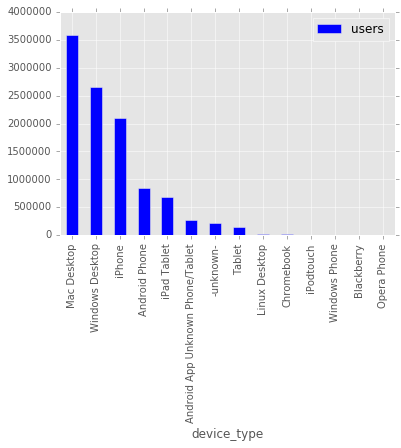

In [49]:
devices = pd.DataFrame(sessions.device_type.value_counts().reset_index())
devices.rename(columns = {'index':'device_type','device_type':'users'}, inplace = True)
devices.plot(x = 'device_type', y='users',kind= 'bar')

So we can see that Apple users are already in our top users, given that Mac Desktop + iPhone would take up first places in Desktop and Mobile Devices. I wonder what happens if we look at Apple devices only, how much to they represent of the total? 

In [54]:
print "Apple users will represent {0}% of the total users.".format(float(devices[devices.device_type.isin(['Mac Desktop','iPhone','iPad Tablet','iPodtouch'])].users.sum()) / float(devices.users.sum()) * 100)

Apple users will represent 60.4758521148% of the total users.


Dude, that's crazy.

In [56]:
less_sessions = sessions[['user_id','action','action_type']]
less_sessions.groupby(['action','action_type']).count()

,,user_id
action,action_type,
10,message_post,3202
11,message_post,702
12,message_post,2204
15,message_post,1053
about_us,-unknown-,412
accept_decline,view,2
account,-unknown-,9004
acculynk_bin_check_failed,-unknown-,1
acculynk_bin_check_success,-unknown-,51


In [66]:
len(sessions.user_id.unique())

135484